## Init

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
cd /content/drive/My\ Drive/CNN-Denoising

/content/drive/My Drive/CNN-Denoising


In [0]:
import numpy as np
import matplotlib.pyplot as plt

import h5py 

from unet import *
import cv2
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np 
import glob
from noise import noisy
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

def loadData(filepath, zidx=0, cidx=0):
    h5_file = h5py.File(filepath)

    data = h5_file.get('x')
    X, Y = [], []
    
    count = 0
    # X, gen. noise        
    for img in data:
        y = (img/255.0).astype('float32')
        noisyImg = noisy('gauss',y, [0,0.05])
        finalImg = np.clip(noisyImg,0,1)
        X.append(finalImg.astype('float32'))
        Y.append(y)
        count += 1
        if count == 1100: break
    
    return np.array(X),np.array(Y)


toTensor = transforms.ToTensor()  
toPIL = transforms.ToPILImage()  


class HDF5Dataset(Dataset):

    def __init__(self, root, category): # highres images not currently scaled, just 96 by default
        import h5py 
        h5_file = h5py.File(root)

        if category == 'train':
            self.data = h5_file.get('x')[:32000]
        else:
            self.data = h5_file.get('x')[32100:]

#         self.trans = transforms.Compose([transforms.ToPILImage(),transforms.Resize(imageSize),transforms.ToTensor()])
                
        self.len = len(self.data)

    def __getitem__(self, index):
        img = self.data[index]
#         hr = toTensor(arr)
        y = (img/255.0).astype('float32')
        noisyImg = noisy('gauss',y, [0,0.05])
        x = np.clip(noisyImg,0,1)
        x,y = toTensor(x.astype('float32')), toTensor(y)
        return x,y

    def __len__(self):
        return self.len        


def load_HDF5_dataset(root, category,shuffle=True,batchSize=6,num_workers=0):

    dataset = HDF5Dataset(root, category)
    dataloader = DataLoader(dataset, batch_size=batchSize,
                                            shuffle=shuffle, num_workers=num_workers)
    return dataloader


In [0]:
dataset=load_HDF5_dataset('camelyonpatch_level_2_split_valid_x.h5','train')

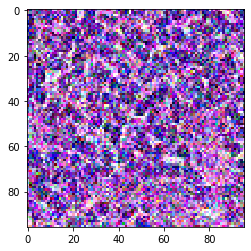

In [10]:
for bat in dataset:
    plt.imshow(toPIL(bat[0][0]))
    break

In [0]:
def PSNR(I0,I1):
    MSE = np.mean( (I0-I1)**2 )
    PSNR = 20*np.log10(1/np.sqrt(MSE))
    return PSNR

### Load

In [0]:
X,Y = loadData('camelyonpatch_level_2_split_valid_x.h5')

nobs = 1000
Xtrain = X[:nobs]
Ytrain = Y[:nobs]
Xtest = X[nobs:nobs+50]
Ytest = Y[nobs:nobs+50]

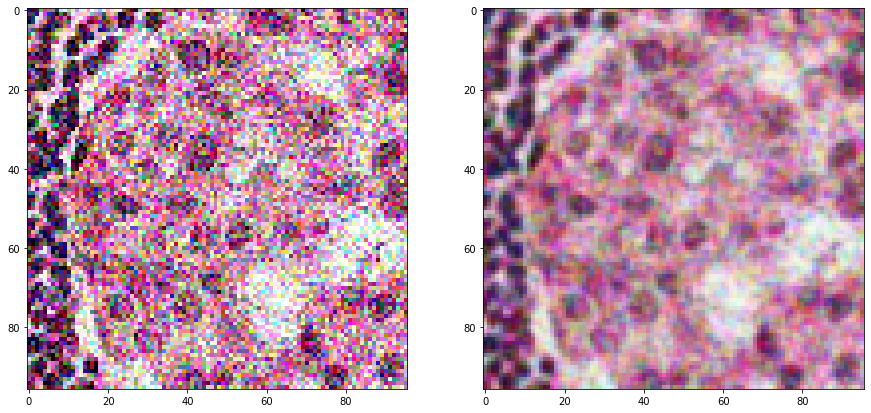

In [14]:
idx = 5
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(X[idx],cmap='gray')

import scipy.ndimage as ndimage
smoothed_img = ndimage.gaussian_filter(X[idx], sigma=(0.7, 0.7, 0.3), order=0)

plt.subplot(1,2,2)
plt.imshow(smoothed_img,cmap='gray')

## Torch

In [0]:
X_train_torch = torch.tensor(Xtrain.transpose(0,3,1,2)).cuda()
Y_train_torch = torch.tensor(Ytrain.transpose(0,3,1,2)).cuda()

In [16]:
import torch.optim as optim

net = UNet(in_channels=3,out_channels=3)
net.to('cuda');

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.002)

lastLoss = 1

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    batchSize = 10
    N = int(len(X_train_torch)/batchSize)
    for i in range(N):#, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = X_train_torch[i*batchSize:(i+1)*batchSize], Y_train_torch[i*batchSize:(i+1)*batchSize]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i/N*100 % 10 == 0:
            print("%0.0f" % (i/N*100.0),end=',')

    lastLoss = running_loss / N
    print(" epoch %d, loss %0.5f" % (epoch,running_loss / N),end=", ")
print("returning - epoch",epoch,"loss",running_loss / N,end=", ")

0,10,20,30,40,50,60,70,80,90, epoch 0, loss 0.09525, 0,10,20,30,40,50,60,70,80,90, epoch 1, loss 0.01321, 0,10,20,30,40,50,60,70,80,90, epoch 2, loss 0.01071, 0,10,20,30,40,50,60,70,80,90, epoch 3, loss 0.00947, 0,10,20,30,40,50,60,70,80,90, epoch 4, loss 0.00884, 0,10,20,30,40,50,60,70,80,90, epoch 5, loss 0.00858, 0,10,20,30,40,50,60,70,80,90, epoch 6, loss 0.00826, 0,10,20,30,40,50,60,70,80,90, epoch 7, loss 0.00810, 0,10,20,30,40,50,60,70,80,90, epoch 8, loss 0.00799, 0,10,20,30,40,50,60,70,80,90, epoch 9, loss 0.00789, returning - epoch 9 loss 0.007888318309560417, 

In [0]:
X_test_torch = torch.tensor(Xtest.transpose(0,3,1,2)).float().cuda()
X_test_torch = torch.tensor(Xtest.transpose(0,3,1,2)).float().cuda()

In [0]:
with torch.no_grad():
    pred = net(X_test_torch)

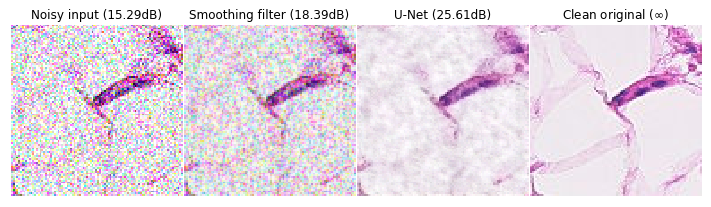

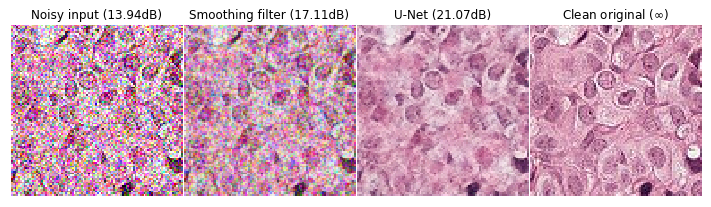

In [0]:
import scipy.ndimage as ndimage

toPIL = transforms.ToPILImage()      
toTensor = transforms.ToTensor()

ind = [2,16]

for idx in ind:
    plt.figure(figsize=(10,5))
    plt.subplot(1,4,1)
    plt.imshow(toPIL(toTensor(Xtest[idx])))    
    plt.gca().axis('off')
    plt.xticks([], [])
    plt.yticks([], [])
    psnr = PSNR(np.clip(Ytest[idx].transpose(2,0,1),0,1),np.clip(Xtest[idx].transpose(2,0,1),0,1))
    plt.title("Noisy input (%0.2fdB)" % psnr)
    
    plt.subplot(1,4,2)
    img = Xtest[idx]
    smoothed_img = ndimage.gaussian_filter(img, sigma=(0.5, 0.5, 0.2), order=0)
    plt.imshow(toPIL(toTensor(smoothed_img)))    
    plt.gca().axis('off')
    plt.xticks([], [])
    plt.yticks([], [])
    psnr = PSNR(np.clip(Ytest[idx].transpose(2,0,1),0,1),np.clip(smoothed_img.transpose(2,0,1),0,1))
    plt.title("Smoothing filter (%0.2fdB)" % psnr)
    
    plt.subplot(1,4,3)
    plt.imshow(np.clip(pred[idx].cpu().numpy().transpose(1,2,0),0,1))
    plt.gca().axis('off')
    plt.xticks([], [])
    plt.yticks([], [])
    psnr = PSNR(np.clip(Ytest[idx].transpose(2,0,1),0,1),np.clip(pred[idx].cpu().numpy(),0,1))
    plt.title("U-Net (%0.2fdB)" % psnr)
    

    plt.subplot(1,4,4)
    plt.imshow(toPIL(toTensor(Ytest[idx])))
    plt.gca().axis('off')
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title("Clean original ($\infty$)")
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.savefig('denoising_' + str(idx) + '.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

    